In [1]:
from random import shuffle
from sys import path_hooks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion() # interactive mode

# Load data

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    }
    
data_dir = "../data/hymenoptera_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# visualize a few images

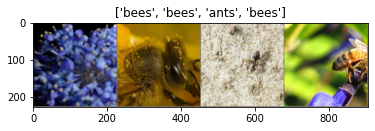

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
        since = time.time()
        
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        
        for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print('-'*10)
            
            for phase in  ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()
                
                running_loss = 0.
                running_corrects = 0
                
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
                print(f"{phase} Loss: {epoch_loss: .4f} Acc: {epoch_acc:.4f}")
                
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                
            print()

        time_elapsed = time.time() - since
        print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60}s")
        print(f"Best val Acc: {best_acc:4f}")
        
        
        model.load_state_dict(best_model_wts)
        return model

# Visualizing the model predictions

In [17]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetuning the convnet

In [18]:
model_ft = models.resnet18(pretrained=True)
num_fts = model_ft.fc.in_features
model_ft.fr = nn.Linear(num_fts, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train and evaluate

In [19]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss:  1.9496 Acc: 0.6393
val Loss:  0.9796 Acc: 0.7386

Epoch 1/24
----------
train Loss:  0.8020 Acc: 0.7459
val Loss:  0.5322 Acc: 0.7582

Epoch 2/24
----------
train Loss:  0.7148 Acc: 0.7336
val Loss:  0.3601 Acc: 0.8431

Epoch 3/24
----------
train Loss:  0.5339 Acc: 0.7623
val Loss:  0.3692 Acc: 0.8824

Epoch 4/24
----------
train Loss:  0.5157 Acc: 0.7910
val Loss:  0.4914 Acc: 0.8431

Epoch 5/24
----------
train Loss:  0.3855 Acc: 0.8361
val Loss:  0.4986 Acc: 0.8366

Epoch 6/24
----------
train Loss:  0.6343 Acc: 0.7336
val Loss:  0.4114 Acc: 0.8170

Epoch 7/24
----------
train Loss:  0.4335 Acc: 0.8197
val Loss:  0.2917 Acc: 0.8889

Epoch 8/24
----------
train Loss:  0.4042 Acc: 0.8197
val Loss:  0.2685 Acc: 0.8889

Epoch 9/24
----------
train Loss:  0.3668 Acc: 0.8320
val Loss:  0.2707 Acc: 0.8824

Epoch 10/24
----------
train Loss:  0.3808 Acc: 0.8197
val Loss:  0.2644 Acc: 0.8954

Epoch 11/24
----------
train Loss:  0.4022 Acc: 0.8156
val Loss:

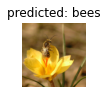

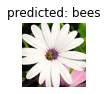

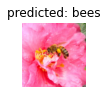

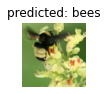

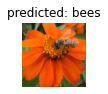

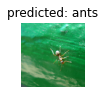

In [20]:
visualize_model(model_ft)

# ConvNet as fixed feature extractor

In [21]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [22]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss:  0.5793 Acc: 0.6844
val Loss:  0.2029 Acc: 0.9412

Epoch 1/24
----------
train Loss:  0.4419 Acc: 0.7910
val Loss:  0.1865 Acc: 0.9412

Epoch 2/24
----------
train Loss:  0.6349 Acc: 0.7459
val Loss:  0.2674 Acc: 0.9150

Epoch 3/24
----------
train Loss:  0.5375 Acc: 0.7787
val Loss:  0.1521 Acc: 0.9477

Epoch 4/24
----------
train Loss:  0.4500 Acc: 0.8156
val Loss:  0.2136 Acc: 0.9346

Epoch 5/24
----------
train Loss:  0.5525 Acc: 0.7664
val Loss:  0.1594 Acc: 0.9477

Epoch 6/24
----------
train Loss:  0.4386 Acc: 0.8115
val Loss:  0.1593 Acc: 0.9477

Epoch 7/24
----------
train Loss:  0.3337 Acc: 0.8730
val Loss:  0.1818 Acc: 0.9542

Epoch 8/24
----------
train Loss:  0.3578 Acc: 0.8197
val Loss:  0.1865 Acc: 0.9346

Epoch 9/24
----------
train Loss:  0.3320 Acc: 0.8648
val Loss:  0.1927 Acc: 0.9346

Epoch 10/24
----------
train Loss:  0.2784 Acc: 0.9057
val Loss:  0.1808 Acc: 0.9477

Epoch 11/24
----------
train Loss:  0.3096 Acc: 0.8730
val Loss:

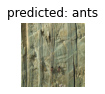

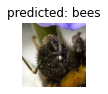

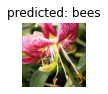

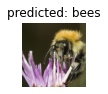

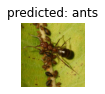

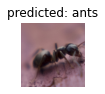

In [23]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [25]:
torch.save(model_conv.state_dict(), 'resnet18_hym.pth')